# DE Africa Coastlines vector statistics <img align="right" src="https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/raw/main/Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

This code conducts vector subpixel shoreline extraction for DE Africa Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, run `dea_coastlines.vector.py`.


---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [ ]:
pip install -r requirements.txt --quiet

In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import array_bounds
from dea_tools.spatial import subpixel_contours

# Load DEA Coastlines code
import dea_coastlines.raster
import dea_coastlines.vector

# Hide Pandas warnings
pd.options.mode.chained_assignment = None


## Load in data

In [3]:
study_area = 399
raster_version = 'testing'
vector_version = 'testing'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2020'

# Load analysis params from config file
config = dea_coastlines.raster.load_config(
    config_path='configs/deafrica_coastlines_config.yaml')

## Load DEA Coastlines rasters

In [4]:
yearly_ds, gapfill_ds = dea_coastlines.vector.load_rasters(
    path='data/interim/raster',
    raster_version=raster_version,
    study_area=study_area,
    water_index=water_index,
    start_year=2000)
print(yearly_ds)

# Create output vector folder
output_dir = f'data/interim/vector/{vector_version}/{study_area}_{vector_version}'
os.makedirs(output_dir, exist_ok=True)

<xarray.Dataset>
Dimensions:  (year: 21, y: 1300, x: 1593)
Coordinates:
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020
  * y        (y) float64 7.117e+05 7.117e+05 7.116e+05 ... 6.728e+05 6.727e+05
  * x        (x) float64 4.389e+05 4.389e+05 4.39e+05 ... 4.866e+05 4.867e+05
Data variables:
    mndwi    (year, y, x) float32 0.4056 0.402 0.4198 ... 0.1183 0.1269 0.1411
    tide_m   (year, y, x) float32 0.2244 0.2244 0.2244 ... 0.02217 0.02217
    count    (year, y, x) int16 4 4 4 4 4 4 4 4 4 ... 10 10 10 10 10 10 10 10 10
    stdev    (year, y, x) float32 0.04299 0.04488 0.08665 ... 0.2932 0.2934
Attributes:
    transform:      | 30.00, 0.00, 438885.00|\n| 0.00,-30.00, 711705.00|\n| 0...
    crs:            +init=epsg:32631
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


## Load vector data

In [5]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Tide points
tide_points_gdf = (gpd.read_file(config['Input files']['coastal_points_path'],
                                 bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
gridcell_gdf = (gpd.read_file(config['Input files']['coastal_grid_path'],
                              bbox=bbox).set_index('id').to_crs(
                                  str(yearly_ds.crs)))
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]


## Extract shoreline contours

### Extract ocean-masked contours

In [6]:
# If a waterbody mask is provided, use this to remove non-coastal
# waterbodies and estuaries from the dataset. If not, use empty mask
if config['Input files']['waterbody_mask_path']:

    # Generate waterbody mask
    print('Generating waterbody mask')
    waterbody_mask = dea_coastlines.vector.waterbody_masking(
        input_data=config['Input files']['waterbody_mask_path'],
        modification_data=config['Input files']['waterbody_modifications_path'],
        bbox=bbox,
        yearly_ds=yearly_ds)
    
else:
    waterbody_mask = np.full(yearly_ds.geobox.shape, False, dtype=bool)
    

In [271]:
# Mask dataset to focus on coastal zone only
masked_ds, certainty_masks = dea_coastlines.vector.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    waterbody_mask,
    tide_points_gdf,
    output_path=output_dir,
    buffer_pixels=25)

<AxesSubplot:>

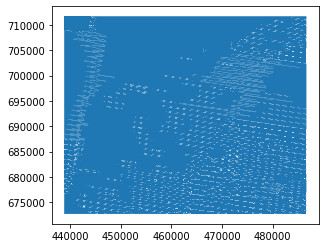

In [272]:
certainty_masks['2006'].plot()

In [185]:

# import topojson as tp




In [266]:
out_vectors = certainty_masks(yearly_ds)

In [270]:
contours_gdf = test_line.overlay(out_vectors['2004'].reset_index(), how='intersection')
contours_gdf.to_crs('EPSG:4326').to_file('test_2004.geojson')

In [257]:
out_vectors[2006].to_crs('EPSG:4326').to_file('test.geojson')

In [234]:
test_line = gpd.read_file('test_line.geojson').to_crs(out_vectors[2016].crs)

# 
# out_vectors[2016].plot(column='certainty', legend=True, vmax=2)

In [233]:
test_line.overlay(out_vectors[2016], how='intersection')   #.to_crs('EPSG:4326')  #.to_file('test.geojson')

,geometry
0,"LINESTRING (476374.966 706780.623, 480344.208 ..."


<AxesSubplot:>

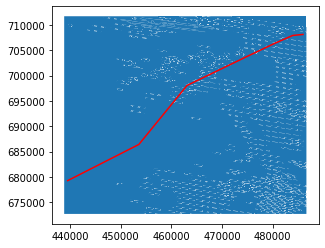

In [253]:
out_vectors[2010].plot()
test_line.plot(ax=plt.gca(), color='red')

,certainty,geometry
0,good,"MULTILINESTRING ((441105.000 680052.369, 44111..."
1,tidal issues,"MULTILINESTRING ((439441.643 679207.072, 44110..."


In [195]:
out_vectors[2000].certainty.astype(int)

0     2
1     2
2     0
3     2
4     2
5     2
6     0
7     2
8     2
9     2
10    0
11    0
12    2
13    2
14    2
15    0
Name: certainty, dtype: int64

In [102]:
from skimage.morphology import binary_opening, binary_closing, binary_erosion
from skimage.morphology import disk, square

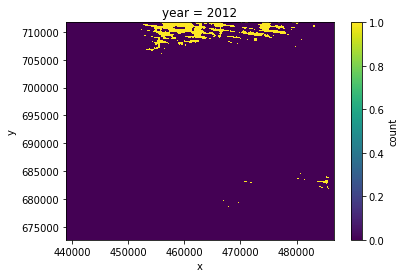

In [63]:
# def _clean_arrays(x):
#     binary_closing(x, disk(5)
from skimage.morphology import reconstruction   #(seed, mask, method='dilation', footprint=None, offset=None)
low_obs.groupby('year').apply(lambda x: binary_closing(x, disk(5))).sel(year=2012).plot()

In [87]:
from skimage.morphology import remove_small_objects, remove_small_holes

In [77]:
remove_small_objects(low_obs, min_size=32)

NameError: name 'x' is not defined

In [92]:
test1 = 

In [81]:
test2 = low_obs.groupby('year').apply(lambda x: remove_small_objects(~x.values, min_size=64))

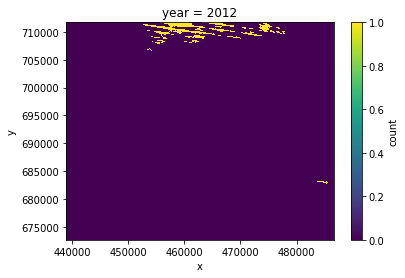

In [91]:
(test1).sel(year=2012).plot()

In [273]:
# Extract contours
contours_gdf = (subpixel_contours(da=masked_ds,
                                  z_values=index_threshold,
                                  min_vertices=10,
                                  dim='year',
                                  output_path=f'temp.geojson')
                .set_index('year'))


In [9]:
test_poly = gpd.read_file('test_poly.geojson')
test_line = gpd.read_file('test_line.geojson')

In [22]:
# test_line.sjoin(test_poly)   

test_line.overlay(test_poly, how='intersection').to_file('test.geojson')

## Compute statistics
### Create stats points on baseline contour

In [274]:
# Extract statistics modelling points along baseline contour
points_gdf = dea_coastlines.vector.points_on_line(contours_gdf,
                                                  baseline_year,
                                                  distance=30)

# If a rocky mask is provided, use this to clip data
if config['Input files']['coastal_classification_path']:

    # Import coastline classification
    print('Clipping to non-rocky shorelines')
    coastal_classification_gdf = (gpd.read_file(
        config['Input files']['coastal_classification_path'],
        bbox=bbox).to_crs(yearly_ds.crs))

    # Clip to remove rocky shoreline points
    points_gdf = dea_coastlines.vector.rocky_shores_clip(
        points_gdf, coastal_classification_gdf, buffer=50)

### Measure annual coastline movements

In [275]:
if points_gdf is not None:  

    # Calculate annual movements and residual tide heights for every 
    # contour compared to the baseline year
    points_gdf = dea_coastlines.vector.annual_movements(points_gdf,
                                              contours_gdf,
                                              yearly_ds,                                     
                                              baseline_year,
                                              water_index)

### Calculate regressions

In [276]:
if points_gdf is not None:

    # Apply regression function to each row in dataset
    points_gdf = dea_coastlines.vector.calculate_regressions(points_gdf,
                                                             contours_gdf)

# Add count and span of valid obs, Shoreline Change Envelope (SCE), 
# Net Shoreline Movement (NSM) and Max/Min years
stats_list = ['valid_obs', 'valid_span', 'sce', 'nsm', 'max_year', 'min_year']
points_gdf[stats_list] = points_gdf.apply(
    lambda x: dea_coastlines.vector.all_time_stats(x, 
                                                   initial_year=2000), axis=1)

Comparing annual movements with time


## Export files

### Export stats files

In [277]:
if points_gdf is not None:
    
    # Set up scheme to optimise file size
    schema_dict = {key: 'float:8.2' for key in points_gdf.columns
                   if key != 'geometry'}
    schema_dict.update({'sig_time': 'float:8.3',
                        'outl_time': 'str:80',
                        'valid_obs': 'int:4',
                        'valid_span': 'int:4',
                        'max_year': 'int:4',
                        'min_year': 'int:4',
                       })
    col_schema = schema_dict.items()

    # Clip stats to study area extent
    stats_path = f'{output_dir}/ratesofchange_{study_area}_' \
                 f'{vector_version}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(gridcell_gdf.geometry.item())]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

### Export contours

In [310]:
# Assign certainty to contours based on underlying masks
# contours_gdf = dea_coastlines.vector.contour_certainty(
#     contours_gdf, 
#     output_path=output_dir)

contours_gdf = dea_coastlines.vector.contour_certainty(
    contours_gdf, 
    certainty_masks)

# Add maturity details
contours_gdf['maturity'] = 'final'
contours_gdf.loc[contours_gdf.index == baseline_year, 'maturity'] = 'interim'

# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/annualshorelines_{study_area}_{vector_version}_' \
               f'{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(gridcell_gdf.geometry.item())
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** November 2021